### Importing Libraries:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords

### Importing dataset :

In [2]:
train_news = pd.read_csv('data/train.csv.zip', index_col = False)
test_news = pd.read_csv('data/test.csv.zip', index_col = None)

### Resulting dataframe

In [3]:
train_news.drop('id', axis = 1)

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


### Dataset Exploration

In [4]:
train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
train_news.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
train_news.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

#### Is the dataset balanced?

In [7]:
train_news.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

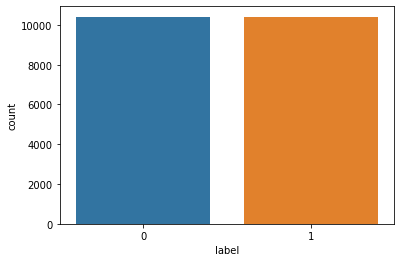

In [8]:
sns.countplot(train_news['label'])

In [9]:
train_news['duplicate'] = train_news.duplicated(subset=['text'])

In [10]:
train_news.groupby(['duplicate', 'label']).label.count()

duplicate  label
False      0        10387
           1        10000
True       1          413
Name: label, dtype: int64

In [11]:
"""The dataset is balanced and there are almost no duplicates, also, the data types are correct. 
There are several null values that we must take a look into"""

'The dataset is balanced and there are almost no duplicates, also, the data types are correct. \nThere are several null values that we must take a look into'

### Dropping duplicates 

In [12]:
train_news.loc[train_news['duplicate'] == True]

,id,title,author,text,label,duplicate
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1,True
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1,True
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1,True
480,480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1,True
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1,True
...,...,...,...,...,...,...
20728,20728,Trump warns of World War III if Clinton is ele...,NaN,Email Donald Trump warned in an interview Tues...,1,True
20749,20749,Realities Faced by Black Canadians are a Natio...,Anonymous,"Tweet Widget by Robyn Maynard \nCanada, includ...",1,True
20750,20750,Why Did Four Googles Kill This White?,Andrew Anglin,Migrant Crisis Disclaimer \nWe here at the Dai...,1,True
20754,20754,No More American Thanksgivings,Glen Ford,Thanksgiving by Glen Ford \n“The core ideologi...,1,True


In [13]:
train_news = train_news.drop((train_news.loc[train_news['duplicate'] == True].index))

#### Treating Null Values

In [14]:
train_news.isnull().sum()

id              0
title         518
author       1854
text            1
label           0
duplicate       0
dtype: int64

In [15]:
train_news.loc[train_news['text'].isnull()]

,id,title,author,text,label,duplicate
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1,False


All this news have no text or author + they are in french, which would make our algorithm to work innacurately since most of our news are in english. We will then drop this rows. 

In [16]:
train_news = train_news.drop((train_news.loc[train_news['text'].isnull()].index).copy())

In [17]:
train_news.loc[train_news['author'].isnull()]

,id,title,author,text,label,duplicate
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,False
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,False
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,False
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,False
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,False
...,...,...,...,...,...,...
20690,20690,Способен ли кто-нибудь помешать Соросу стать «...,NaN,Регион: США в мире Как отмечает в своей новой ...,1,False
20718,20718,This Is The Best Picture In Human History | Da...,NaN,This Is The Best Picture In Human History By: ...,1,False
20745,20745,Thomas Frank Explores Whether Hillary Clinton ...,NaN,Thomas Frank Explores Whether Hillary Clinton ...,1,False
20768,20768,Osama bin Laden’s older brother rents out luxu...,NaN,Osama bin Laden’s older brother rents out luxu...,1,False


In [18]:
"""The author column is not on our other dataset, so it should be too important, however we are going to 
see if the Fake News are the ones without author"""

'The author column is not on our other dataset, so it should be too important, however we are going to \nsee if the Fake News are the ones without author'

In [19]:
train_news.loc[train_news['author'].isnull()]['label'].value_counts()

1    1827
0      26
Name: label, dtype: int64

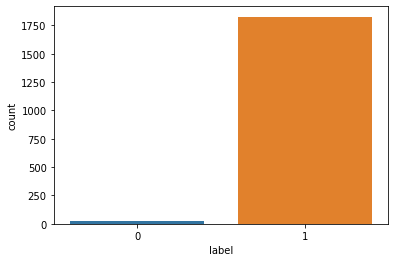

In [20]:
sns.countplot(train_news.loc[train_news['author'].isnull()]['label'])

In [21]:
'''Most of the news that have not an author are fake. So instead dropping this lines, we are going to replace them 
with the value Anonymous, since it could be a key column for our algorithm'''

'Most of the news that have not an author are fake. So instead dropping this lines, we are going to replace them \nwith the value Anonymous, since it could be a key column for our algorithm'

In [22]:
train_news['author'] = train_news['author'].replace(np.nan, 'Anonymous').copy()

In [23]:
train_news.isnull().sum()

id             0
title        518
author         0
text           0
label          0
duplicate      0
dtype: int64

Last, we have to treat the null values from the title. Let's check out how many rows also come from an Anonymous source. In that case, we will drop them because the information provided originally was too little. 
Otherwise, we won't drop them since the title and the text are going to be analized together.

In [24]:
train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')]

,id,title,author,text,label,duplicate
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,False
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,False
562,562,NaN,Anonymous,Field is correct about the 8a companies and Tr...,1,False
1322,1322,NaN,Anonymous,Georg Soros the good oil . http://mailstar.net...,1,False
2559,2559,NaN,Anonymous,The green fraud has a lot to do with it all as...,1,False
2671,2671,NaN,Anonymous,"Hell thats a good speech , maybe there is more...",1,False
3247,3247,NaN,Anonymous,"Everybody send it to Drudge, infowars lets see...",1,False
3309,3309,NaN,Anonymous,Haha! Your Hillary agents are writing this cru...,1,False
3398,3398,NaN,Anonymous,"He has got to go after him , he is the one cau...",1,False
3945,3945,NaN,Anonymous,Its not a bad idea paiting their faces same as...,1,False


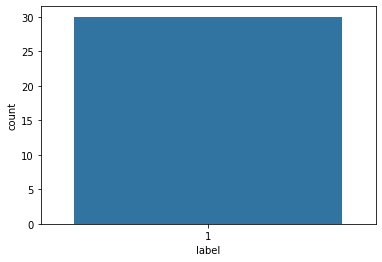

In [25]:
sns.countplot(train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')]['label'])

In [26]:
#dropping these rows

train_news = train_news.drop((train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')].index))

In [27]:
train_news.isnull().sum()

id             0
title        488
author         0
text           0
label          0
duplicate      0
dtype: int64

In [28]:
train_news['mergedtext'] = train_news['title'] + train_news['text']

In [29]:
train_news.isnull().sum()

id              0
title         488
author          0
text            0
label           0
duplicate       0
mergedtext    488
dtype: int64

In [30]:
train_news.loc[train_news.title.isnull()]

,id,title,author,text,label,duplicate,mergedtext
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1,False,NaN
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1,False,NaN
196,196,NaN,Raffie,They got the heater turned up on high.,1,False,NaN
223,223,NaN,PhilSilversGhost,If I were one of those Guardsmen and the Spets...,1,False,NaN
288,288,NaN,beersession,The way he's doing business there seems he'll ...,1,False,NaN
...,...,...,...,...,...,...,...
20568,20568,NaN,Cathy Milne,"Amusing comment Gary! “Those week!” So, are ...",1,False,NaN
20627,20627,NaN,Ramona,"No she doesn’t have more money than God, every...",1,False,NaN
20636,20636,NaN,Dave Lowery,Trump all the way!,1,False,NaN
20771,20771,NaN,Letsbereal,DYN's Statement on Last Week's Botnet Attack h...,1,False,NaN


In [31]:
train_news.mergedtext.fillna(train_news.text, inplace=True)

In [32]:
train_news.isnull().sum()

id              0
title         488
author          0
text            0
label           0
duplicate       0
mergedtext      0
dtype: int64

### Resulting dataset

In [33]:
train_news = train_news.drop(['id', 'title','duplicate','text'], axis=1)

In [34]:
train_news.head(10)

,author,label,mergedtext
0,Darrell Lucus,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,Daniel J. Flynn,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Consortiumnews.com,1,Why the Truth Might Get You FiredWhy the Truth...
3,Jessica Purkiss,1,15 Civilians Killed In Single US Airstrike Hav...
4,Howard Portnoy,1,Iranian woman jailed for fictional unpublished...
5,Daniel Nussbaum,0,Jackie Mason: Hollywood Would Love Trump if He...
6,Anonymous,1,Life: Life Of Luxury: Elton John’s 6 Favorite ...
7,Alissa J. Rubin,0,Benoît Hamon Wins French Socialist Party’s Pre...
8,Anonymous,0,Excerpts From a Draft Script for Donald Trump’...
9,Megan Twohey and Scott Shane,0,"A Back-Channel Plan for Ukraine and Russia, Co..."


In [38]:
train_news = train_news[['author', 'mergedtext', 'label']]

In [39]:
train_news.to_csv('data/train_news.csv')

### Can we extract a source from the text?

In [40]:
train_news['mergedtext'][7]

'Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York TimesPARIS  —   France chose an idealistic, traditional   candidate in Sunday’s primary to represent the Socialist and   parties in the presidential election this spring. The candidate, Benoît Hamon, 49, who ran on the slogan that he would “make France’s heart beat,” bested Manuel Valls, the former prime minister, whose campaign has promoted more   policies and who has a strong    background. Mr. Hamon appeared to have won by a wide margin, with incomplete returns showing him with an estimated 58 percent of the vote to Mr. Valls’s 41 percent. “Tonight the left holds its head up high again it is looking to the future,” Mr. Hamon said, addressing his supporters. “Our country needs the left, but a modern, innovative left,” he said. Mr. Hamon’s victory was the clearest sign yet that voters on the left want a break with the policies of President François Hollande, who in December announced that he would not s

In [ ]:
'''After a slash ''-'''
'''The author is in the text and the source in the author column'''
'''Breitbart source'''

'''We are going to apply two formats: look after any slash and anything containing breitbart. Also we are 
going to check the autors column to double check its veracity'''

In [41]:
def source(txt):
    return re.findall('(?<=\-)D', txt)
    return re.findall('/-([^-])-/', txt)

In [42]:
train_news.loc[train_news['author'].str.contains('com')]

,author,mergedtext,label
2,Consortiumnews.com,Why the Truth Might Get You FiredWhy the Truth...,1
141,beforeitsnews.com,It Literally Hurts My Brain to Read the Econom...,1
161,Dikran Arakelian (noreply@blogger.com),The Top 10 Places In The World You're NOT Allo...,1
194,Consortiumnews.com,Death of the ‘Two-State Solution’Death of the ...,1
257,noreply@blogger.com (Der Postillon),Newsticker (974)+++ Hände weg vom Alkohol: Sch...,1
...,...,...,...
20662,Dikran Arakelian (noreply@blogger.com),The Truth U.S. Government Does NOT Want You To...,1
20716,Jason Ditz | Antiwar.com,US Calls On Saudi Arabia To End Airstrikes Aga...,1
20735,Consortiumnews.com,The Political World After Trump’s WinThe Polit...,1
20740,noreply@blogger.com (Der Postillon),Kleiner Vorgeschmack: Erdogan lässt Warnflücht...,1


In [ ]:
train_news['source']= 

In [ ]:
train_news.loc[train_news['text'].str.contains('by')]

In [ ]:
train_news.isnull().sum()